In [ ]:
pip install numpy


In [9]:
import pandas as pd

# Load CSV files
train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('validation.csv')
test_df = pd.read_csv('test.csv')

# Print shape of each dataset to confirm loading
print("Train set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)


Train set shape: (287113, 3)
Validation set shape: (13368, 3)
Test set shape: (11490, 3)


In [10]:
    # Take only 1% of each dataset 
train_sample = train_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
valid_sample = valid_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
test_sample = test_df.sample(frac=0.01, random_state=42).reset_index(drop=True)

# Print new shapes
print("\nAfter sampling 1%:")
print("Train:", train_sample.shape)
print("Validation:", valid_sample.shape)
print("Test:", test_sample.shape)



After sampling 1%:
Train: (2871, 3)
Validation: (134, 3)
Test: (115, 3)


for labelled dateset

In [ ]:
import pandas as pd
import nltk
nltk.download('punkt')

# Function to create labeled dataset from structured data
def create_labeled_dataset(structure_data, split_name=""):
    labeled_data = []
    for doc_id, structure in enumerate(structure_data):
        first_paragraph = True
        for segment in structure:
            sentences = segment['sentences']
            seg_type = segment['type']
            para_id = segment['paragraph_id']

            for sent_id, sentence in enumerate(sentences):
                sentence = sentence.strip()
                if not sentence or len(sentence) < 5:
                    continue

                if seg_type == 'header':
                    label = 'header'
                else:
                    if first_paragraph and sent_id == 0:
                        label = 'subheader'
                    else:
                        label = 'paragraph'

                labeled_data.append({
                    'doc_id': doc_id,
                    'para_id': para_id,
                    'sent_id': sent_id,
                    'sentence': sentence,
                    'label': label
                })

            if seg_type == 'paragraph':
                first_paragraph = False
    
    df = pd.DataFrame(labeled_data)
    print(f" {split_name.capitalize()} labeled dataset created. Total sentences: {len(df)}")
    print(df['label'].value_counts(), "\n")
    return df

# Apply to all splits
train_labeled_df = create_labeled_dataset(train_sample['structure'], split_name='train')
val_labeled_df   = create_labeled_dataset(valid_sample['structure'], split_name='val')
test_labeled_df  = create_labeled_dataset(test_sample['structure'], split_name='test')

# Save to CSVs
train_labeled_df.to_csv("labeled_dataset_train.csv", index=False)
val_labeled_df.to_csv("labeled_dataset_val.csv", index=False)
test_labeled_df.to_csv("labeled_dataset_test.csv", index=False)

print(" All labeled datasets saved: train, val, test.")


In [ ]:
import pandas as pd
import torch
import json
from tqdm import tqdm

# Helper: Load structure and embeddings
def load_data_for_split(split_name):
    df = pd.read_csv(f"labeled_dataset_{split_name}.csv")
    embeddings = torch.load(f"{split_name}_sentence_embeddings.pt")
    return df, embeddings

# Helper: Extract sentences + mapping
def extract_all_sentences(structured_articles):
    all_sentences = []
    mapping = []  # (doc_id, para_id, sent_id)
    for doc_id, article_structure in enumerate(structured_articles):
        for para in article_structure:
            para_id = para['paragraph_id']
            for sent_id, sentence in enumerate(para['sentences']):
                all_sentences.append(sentence)
                mapping.append((doc_id, para_id, sent_id))
    return all_sentences, mapping

# Processing function
def process_labeled_split(split_name, sample_df):
    print(f"\n Processing split: {split_name}")

    # Step 1: Load labeled sentences and embeddings
    labeled_df, embeddings = load_data_for_split(split_name)
    print(f" Loaded labeled dataset: {len(labeled_df)} rows")
    print(f" Loaded embeddings: {embeddings.shape}")

    # Step 2: Extract sentences and map from structure
    structured_articles = sample_df['structure'].tolist()
    sentences, sentence_map = extract_all_sentences(structured_articles)

    if len(sentences) != embeddings.shape[0]:
        print(" Warning: Sentence count mismatch with embeddings. Truncating.")
        sentence_map = sentence_map[:embeddings.shape[0]]
        sentences = sentences[:embeddings.shape[0]]

    # Step 3: Create sentence map DataFrame
    map_df = pd.DataFrame(sentence_map, columns=['doc_id', 'para_id', 'sent_id'])
    map_df['embedding_idx'] = map_df.index

    # Step 4: Merge
    merged_df = labeled_df.merge(map_df, on=['doc_id', 'para_id', 'sent_id'], how='left')
    missing = merged_df['embedding_idx'].isna().sum()
    if missing > 0:
        print(f"  {missing} sentences missing embeddings. Dropping them.")
        merged_df = merged_df.dropna(subset=['embedding_idx'])

    # Step 5: Assign embeddings
    embeddings_list = []
    for idx in tqdm(merged_df['embedding_idx'], desc=f"{split_name} - Assigning embeddings"):
        idx = int(idx)
        if idx < embeddings.shape[0]:
            embedding = embeddings[idx].cpu().numpy()
            embeddings_list.append(embedding)
        else:
            embeddings_list.append(None)
    merged_df['embedding'] = embeddings_list

    # Step 6: Save
    merged_df.to_pickle(f"labeled_dataset_with_embeddings_{split_name}.pkl")
    print(f"  Saved: labeled_dataset_with_embeddings_{split_name}.pkl ({len(merged_df)} rows)")

    # Save metadata
    metadata = {
        'split': split_name,
        'num_articles': len(sample_df),
        'num_sentences': len(sentences),
        'sentence_map': sentence_map[:10],
        'sample_sentences': sentences[:10]
    }
    with open(f"stage1_output_metadata_{split_name}.json", "w") as f:
        json.dump(metadata, f, indent=2)
    print(f" Metadata saved: stage1_output_metadata_{split_name}.json")

# Apply to all splits
process_labeled_split("train", train_sample)
process_labeled_split("val", valid_sample)
process_labeled_split("test", test_sample)


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle

# Load updated 1% split datasets
train_df = pd.read_pickle('labeled_dataset_with_embeddings_train.pkl')
val_df   = pd.read_pickle('labeled_dataset_with_embeddings_val.pkl')
test_df  = pd.read_pickle('labeled_dataset_with_embeddings_test.pkl')

print(f"Loaded: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

# Encode labels
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['label'])
val_df['label_encoded']   = label_encoder.transform(val_df['label'])
test_df['label_encoded']  = label_encoder.transform(test_df['label'])

print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

# Dataset class
class TextDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Convert to datasets
train_dataset = TextDataset(list(train_df['embedding']), train_df['label_encoded'].values)
val_dataset   = TextDataset(list(val_df['embedding']),   val_df['label_encoded'].values)
test_dataset  = TextDataset(list(test_df['embedding']),  test_df['label_encoded'].values)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32)
test_loader  = DataLoader(test_dataset,  batch_size=32)

# Model definition
class Classifier(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, num_classes=3):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model
device = torch.device('cpu')  # or 'cuda' if using GPU
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Training loop
def train_model(model, train_loader, val_loader, num_epochs=20, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break
# Train
train_model(model, train_loader, val_loader)

# Save final model and label encoder
torch.save(model.state_dict(), 'classifier_model.pt')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print(" Step 3: Final model and label encoder saved.")



In [ ]:
print(train_sample["highlights"].iloc[0])

People enjoyed temperatures of 17C at Brighton beach in West Sussex and Weymouth in Dorset .
Asda claims it will sell a million sausages over long weekend despite night temperatures dropping to minus 1C .
But the good weather has not been enjoyed by all as the north west and Scotland have seen heavy rain .


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle


# Load trained components
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# BiLSTM + Attention Classifier
class BiLSTM_Attn_Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM_Attn_Classifier, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.attention_fc = nn.Linear(hidden_dim * 2, 1)
        self.classifier = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)
        lstm_out, _ = self.bilstm(x)
        attn_weights = F.softmax(self.attention_fc(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        output = self.classifier(context_vector)
        return output

# Load model and label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

input_dim = 768
hidden_dim = 256
output_dim = len(label_encoder.classes_)

model = BiLSTM_Attn_Classifier(input_dim, hidden_dim, output_dim)
model.load_state_dict(torch.load('classifier_model.pt', map_location=device))
model.to(device)
model.eval()

BiLSTM_Attn_Classifier(
  (bilstm): LSTM(768, 256, batch_first=True, bidirectional=True)
  (attention_fc): Linear(in_features=512, out_features=1, bias=True)
  (classifier): Linear(in_features=512, out_features=3, bias=True)
)

In [33]:
import torch
checkpoint = torch.load('classifier_model.pt', map_location='cpu')
print(checkpoint.keys())  # View state_dict keys
print(checkpoint['classifier.weight'].shape)  # Confirm output_dim=3

odict_keys(['bilstm.weight_ih_l0', 'bilstm.weight_hh_l0', 'bilstm.bias_ih_l0', 'bilstm.bias_hh_l0', 'bilstm.weight_ih_l0_reverse', 'bilstm.weight_hh_l0_reverse', 'bilstm.bias_ih_l0_reverse', 'bilstm.bias_hh_l0_reverse', 'attention_fc.weight', 'attention_fc.bias', 'classifier.weight', 'classifier.bias'])
torch.Size([3, 512])


preprocessing and structural parsing

In [ ]:
import os 
import pickle
import torch
from sentence_transformers import SentenceTransformer
import pandas as pd
import re
from tqdm import tqdm
import nltk

# Ensure nltk is installed and download required data
nltk.download('punkt')

# Load the model once
bert_model = SentenceTransformer('all-mpnet-base-v2')

# Helper: Extract sentences + mapping
def extract_all_sentences(structured_articles):
    all_sentences = []
    mapping = []  # (doc_id, para_id, sent_id)

    for doc_id, article_structure in enumerate(structured_articles):
        for para in article_structure:
            para_id = para['paragraph_id']
            for sent_id, sentence in enumerate(para['sentences']):
                all_sentences.append(sentence)
                mapping.append((doc_id, para_id, sent_id))
    return all_sentences, mapping

# Helper: Process the DataFrame to extract structure using trained model
def process_article(article, article_idx):
    if pd.isna(article) or not article.strip():
        return []
    paragraphs = re.split(r'\n{2,}|\n', article)  # Split based on double newlines or single newlines
    return [{'id': f'{article_idx}_{i}', 'text': p.strip()} for i, p in enumerate(paragraphs) if p.strip()]

def tokenize_sentences(text):
    return [s for s in nltk.sent_tokenize(text) if any(len(w) >= 3 for w in nltk.word_tokenize(s) if w.isalnum())]

def embed_and_classify(paragraphs, model, label_encoder, batch_size=128):
    texts = [p['text'] for p in paragraphs]
    para_ids = [p['id'] for p in paragraphs]

    print(f" Embedding {len(texts)} paragraphs...")
    embeddings = bert_model.encode(texts, convert_to_tensor=True, batch_size=batch_size)

    # Assuming you have your BiLSTM-Attn model here for classification
    print(" Predicting labels using BiLSTM-Attn classifier...")
    with torch.no_grad():
        logits = model(embeddings)  # Use your trained BiLSTM-Attn model here
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        labels = label_encoder.inverse_transform(preds)  # Assuming you have a label encoder

    results = []
    for pid, label, text in zip(para_ids, labels, texts):
        aid, para_idx = map(int, pid.split('_'))
        sentences = tokenize_sentences(text)
        if sentences:
            results.append({
                'article_id': aid,
                'paragraph_id': para_idx,
                'type': label,
                'sentences': sentences
            })
    return results

def process_dataframe(df, model, label_encoder):
    print(" Step 1: Segmenting all articles into paragraphs...")
    all_paragraphs = []
    for idx, article in tqdm(enumerate(df['article']), total=len(df), desc="Segmenting Articles"):
        segs = process_article(article, idx)
        all_paragraphs.extend(segs)

    print(f" Step 2: Embedding + Classifying {len(all_paragraphs)} paragraphs...")
    results = embed_and_classify(all_paragraphs, model, label_encoder)

    print(" Step 3: Grouping results back into article structure...")
    structured_by_article = {}

    for r in results:
        aid = r['article_id']
        structured_by_article.setdefault(aid, []).append({
            'paragraph_id': r['paragraph_id'],
            'type': r['type'],
            'sentences': r['sentences']
        })  

    print(" Step 4: Assigning structure and article_id back to DataFrame...")

    # This ensures proper 1:1 mapping
    df['structure'] = [structured_by_article.get(i, []) for i in tqdm(range(len(df)), desc="Finalizing Structure")]
    df['article_id'] = df.index  # Assigning article_id from DataFrame index (guaranteed match)

    print(" Stage 1 complete.")
    return df['structure']


# Example assumes you've already run classification and have model/label_encoder loaded

# Process and update the DataFrame with structure for train, valid, and test datasets
train_sample['structure'] = process_dataframe(train_sample, model, label_encoder)
valid_sample['structure'] = process_dataframe(valid_sample, model, label_encoder)
test_sample['structure'] = process_dataframe(test_sample, model, label_encoder)

# Save them with structure and article_id so you can reuse later
train_sample.to_pickle("train_with_structure_and_article_id.pkl")
valid_sample.to_pickle("val_with_structure_and_article_id.pkl")
test_sample.to_pickle("test_with_structure_and_article_id.pkl")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eggon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Step 1: Segmenting all articles into paragraphs...


Segmenting Articles: 100%|██████████| 2871/2871 [00:00<00:00, 6299.44it/s]


 Step 2: Embedding + Classifying 2871 paragraphs...
 Embedding 2871 paragraphs...
 Predicting labels using BiLSTM-Attn classifier...
 Step 3: Grouping results back into article structure...
 Step 4: Assigning structure and article_id back to DataFrame...


Finalizing Structure: 100%|██████████| 2871/2871 [00:00<00:00, 950497.02it/s]


 Stage 1 complete.
 Step 1: Segmenting all articles into paragraphs...


Segmenting Articles: 100%|██████████| 134/134 [00:00<00:00, 2543.56it/s]

 Step 2: Embedding + Classifying 134 paragraphs...
 Embedding 134 paragraphs...


 Predicting labels using BiLSTM-Attn classifier...
 Step 3: Grouping results back into article structure...
 Step 4: Assigning structure and article_id back to DataFrame...


Finalizing Structure: 100%|██████████| 134/134 [00:00<?, ?it/s]


 Stage 1 complete.
 Step 1: Segmenting all articles into paragraphs...


Segmenting Articles: 100%|██████████| 115/115 [00:00<00:00, 1970.32it/s]

 Step 2: Embedding + Classifying 115 paragraphs...
 Embedding 115 paragraphs...


 Predicting labels using BiLSTM-Attn classifier...
 Step 3: Grouping results back into article structure...
 Step 4: Assigning structure and article_id back to DataFrame...


Finalizing Structure: 100%|██████████| 115/115 [00:00<?, ?it/s]

 Stage 1 complete.


In [4]:
import pickle

with open('train_with_structure_and_article_id.pkl', 'rb') as file:
    data = pickle.load(file)

# Check and print 2 full-length articles
if isinstance(data, list):
    for i in range(min(2, len(data))):
        print(f"Article {i+1}:\n{data[i]}\n{'-'*80}")
elif isinstance(data, dict):
    for i, (key, value) in enumerate(data.items()):
        print(f"Article {i+1} ID: {key}\nContent:\n{value}\n{'-'*80}")
        if i == 1:
            break
else:
    print("Unsupported data type:", type(data))
    print("Preview:", data)


Unsupported data type: <class 'pandas.core.frame.DataFrame'>
Preview:                                             id  \
0     ed0fed726929c1eeabe6c390e47128dbb7d7a055   
1     023cd84001b33aed4ff0f3f5ecb0fdd2151cf543   
2     6a70a0d8d3ed365fe1df6d35f1587a8b9b298618   
3     b37204c13ea38b511265e41ac69fb12acfb63f85   
4     c24e5805afd5145bc48410e876db91d44a06be5e   
...                                        ...   
2866  9ddececa81dae92cb8a8f385f5fdbb6e138aa3f4   
2867  c87fc65a0beeae74cc0dc411c2103a52968e1374   
2868  dc9e61006c1e5689d6f8c99ef2703ac49659e308   
2869  ba355bd2f4d3b4abf9381dd26b1e78e254c89027   
2870  ccc2b5c8f53847c876df383f714b02097f70162c   

                                                article  \
0     By . Mia De Graaf . Britons flocked to beaches...   
1     A couple who weighed a combined 32st were sham...   
2     Video footage shows the heart stopping moment ...   
3     Istanbul, Turkey (CNN) -- About 250 people rac...   
4     By . Daily Mail Reporter . P

In [ ]:
print(train_sample.columns)


Index(['id', 'article', 'highlights', 'structure', 'article_id'], dtype='object')


Embedding generation

In [ ]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# Load data from train, validation, and test files
train_df = pd.read_pickle("train_with_structure_and_article_id.pkl")
val_df = pd.read_pickle("val_with_structure_and_article_id.pkl")
test_df = pd.read_pickle("test_with_structure_and_article_id.pkl")

# Function to flatten structure into sentence-level records
def flatten_structure(df):
    records = []
    for idx, row in df.iterrows():
        article_id = row['article_id']
        highlights = row.get('highlights', '')
        structure = row.get('structure', [])
        
        for para in structure:
            para_id = para['paragraph_id']
            for sentence in para['sentences']:
                records.append({
                    'article_id': article_id,
                    'paragraph_id': para_id,
                    'sentence': sentence,
                    'highlights': highlights
                })
    return pd.DataFrame(records)

# Flatten all splits (train, val, test)
train_sentence_df = flatten_structure(train_df)
val_sentence_df = flatten_structure(val_df)
test_sentence_df = flatten_structure(test_df)

# Concatenate all splits into a single dataframe for processing
sentence_df = pd.concat([train_sentence_df, val_sentence_df, test_sentence_df], ignore_index=True)

# Load pretrained MPNet model for sentence embeddings
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings
embeddings = []
for sentence in tqdm(sentence_df['sentence'], desc="Generating MPNet embeddings"):
    emb = model.encode(sentence)
    embeddings.append(emb)

# Add embeddings to the dataframe
sentence_df['embedding'] = embeddings

# Save the sentence-level dataset with embeddings
sentence_df.to_pickle("final_sentence_level_dataset_with_all_mpnet.pkl")
print("Saved sentence-level dataset with all-mpnet-base-v2 embeddings: final_sentence_level_dataset_with_all_mpnet.pkl")


Generating MPNet embeddings: 100%|██████████| 120565/120565 [1:56:10<00:00, 17.30it/s] 


Saved sentence-level dataset with all-mpnet-base-v2 embeddings: final_sentence_level_dataset_with_all_mpnet.pkl


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_pickle("final_sentence_level_dataset_with_all_mpnet.pkl")

# Check the first few rows
print(df.head())

# Check column names
print("\n🧾 Columns in the dataset:")
print(df.columns.tolist())


   article_id  paragraph_id  \
0           0             0   
1           0             0   
2           0             0   
3           0             0   
4           0             0   

                                            sentence  \
0                                     Mia De Graaf .   
1  Britons flocked to beaches across the southern...   
2  Temperatures soared to 17C in Brighton and Dor...   
3  Figures from Asda suggest the unexpected sunsh...   
4  Sun's out: Brighton beach was packed with Brit...   

                                          highlights  \
0  People enjoyed temperatures of 17C at Brighton...   
1  People enjoyed temperatures of 17C at Brighton...   
2  People enjoyed temperatures of 17C at Brighton...   
3  People enjoyed temperatures of 17C at Brighton...   
4  People enjoyed temperatures of 17C at Brighton...   

                                           embedding  
0  [0.017809153, 0.09870978, 0.032285955, -0.0337...  
1  [-0.026629565, -0.03104957

K-means Clustering

Semantic clustering and segmentation completed successfully!


Choosing best K:  11%|█         | 1/9 [08:44<1:09:53, 524.19s/K]

K=2 → Silhouette Score: 0.0171


Choosing best K:  22%|██▏       | 2/9 [15:08<51:34, 442.06s/K]  

K=3 → Silhouette Score: 0.0160


Choosing best K:  33%|███▎      | 3/9 [21:33<41:34, 415.75s/K]

K=4 → Silhouette Score: 0.0182


Choosing best K:  44%|████▍     | 4/9 [27:55<33:31, 402.36s/K]

K=5 → Silhouette Score: 0.0173


Choosing best K:  56%|█████▌    | 5/9 [34:16<26:19, 394.82s/K]

K=6 → Silhouette Score: 0.0179


Choosing best K:  67%|██████▋   | 6/9 [40:41<19:34, 391.34s/K]

K=7 → Silhouette Score: 0.0165


Choosing best K:  78%|███████▊  | 7/9 [47:02<12:56, 388.12s/K]

K=8 → Silhouette Score: 0.0179


Choosing best K:  89%|████████▉ | 8/9 [53:23<06:25, 385.81s/K]

K=9 → Silhouette Score: 0.0188


Choosing best K: 100%|██████████| 9/9 [59:45<00:00, 398.36s/K]

K=10 → Silhouette Score: 0.0192


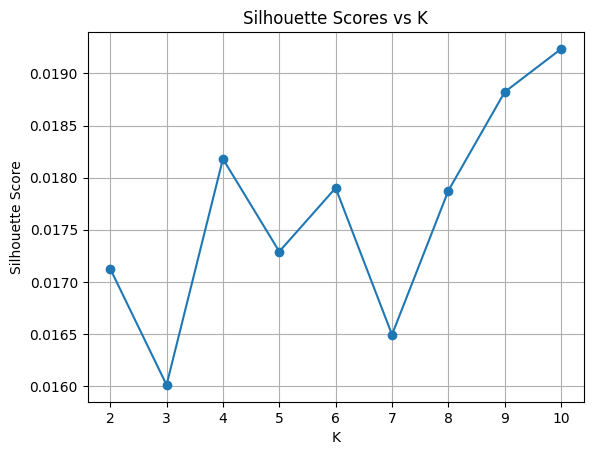

 Best K found: 10 with score 0.0192
Saved sentence-level dataset with dynamic cluster_id as: sentence_level_dataset_with_clusters.pkl


Saving clustered sections: 100%|██████████| 120565/120565 [00:03<00:00, 33635.21sentence/s]


Semantic segmentation into 10 clusters complete.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

# Load dataset with MPNet embeddings
df = pd.read_pickle("final_sentence_level_dataset_with_all_mpnet.pkl")
embeddings = np.vstack(df['embedding'].values)

# Step 1: Automatically choose best K using silhouette score
def choose_best_k(embeddings, min_k=2, max_k=10):
    best_score = -1
    best_k = min_k
    scores = []
    
    for k in tqdm(range(min_k, max_k + 1), desc="Choosing best K", unit="K"):
        kmeans = KMeans(n_clusters=k, random_state=42)  # Removed n_jobs
        labels = kmeans.fit_predict(embeddings)
        score = silhouette_score(embeddings, labels)
        scores.append(score)
        print(f"K={k} → Silhouette Score: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_k = k

    # Plot scores for reference
    plt.plot(range(min_k, max_k + 1), scores, marker='o')
    plt.title("Silhouette Scores vs K")
    plt.xlabel("K")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

    print(f" Best K found: {best_k} with score {best_score:.4f}")
    return best_k

# Show progress after completion of step 1
tqdm.write("Semantic clustering and segmentation completed successfully!")

# Find the best K dynamically
best_k = choose_best_k(embeddings, min_k=2, max_k=10)

# Step 2: Perform KMeans with best K
kmeans = KMeans(n_clusters=best_k, random_state=42)  # Removed n_jobs
cluster_labels = kmeans.fit_predict(embeddings)
df['cluster_id'] = cluster_labels

# Save updated DataFrame
df.to_pickle("sentence_level_dataset_with_clusters.pkl")
print("Saved sentence-level dataset with dynamic cluster_id as: sentence_level_dataset_with_clusters.pkl")

# Step 3: Save clustered sections
sections_by_cluster = defaultdict(list)
for i, row in tqdm(df.iterrows(), total=df.shape[0], desc="Saving clustered sections", unit="sentence"):
    sections_by_cluster[row['cluster_id']].append(row['sentence'])

with open("semantic_clusters.json", "w") as f:
    json.dump({f"Cluster_{k}": v for k, v in sections_by_cluster.items()}, f, indent=2)

# Show final progress message
tqdm.write(f"Semantic segmentation into {best_k} clusters complete.")


In [ ]:
import pandas as pd
import json

# Load cluster-assigned dataset
df = pd.read_pickle("sentence_level_dataset_with_clusters.pkl")

# Load cluster-to-sentences mapping
with open("semantic_clusters.json", "r") as f:
    sections_by_cluster = json.load(f)

# Convert keys to integers
sections_by_cluster = {int(k.replace("Cluster_", "")): v for k, v in sections_by_cluster.items()}

# Print sample sentences from some clusters
best_k = df['cluster_id'].nunique()
num_clusters_to_print = min(5, best_k)
num_sentences_to_show = 5

print("\n=== Sample Sentences from Clusters ===\n")
for cluster_id in range(num_clusters_to_print):
    print(f"\n--- Cluster {cluster_id} ---")
    cluster_sentences = sections_by_cluster[cluster_id][:num_sentences_to_show]
    for idx, sentence in enumerate(cluster_sentences, 1):
        print(f"{idx}. {sentence}")



=== Sample Sentences from Clusters ===


--- Cluster 0 ---
1. is expected to cast over northern and western areas of the country, with .
2. Istanbul, Turkey (CNN) -- About 250 people raced across the Syrian border into Turkey, government officials said Saturday, a flight that reflects the fear and violence gripping the Arab nation.
3. Turkish Foreign Ministry spokesman Selcuk Unal said the government is trying to determine more about the people and how and why they chose to leave Syria.
4. "They just came to the border post and want to go in without passports.
5. Yaylidagi Mayor Mustafa Kemal Dagistanli and another local government official, who asked not to be named, said the people are Syrian citizens and Muslims.

--- Cluster 1 ---
1. A couple who weighed a combined 32st were shamed into slimming by their own family - during Christmas dinner.
2. Our weight loss has helped the kids as well.
3. 'Weight Watchers is easy to follow.
4. We tried other diets before, but this is the one we

Semantic segmentation to cluster sentences into sections

In [ ]:
import pandas as pd
#Saved to: sentence_level_dataset_with_sections.pkl"
# Step 1: Load dataset with clusters
df = pd.read_pickle("sentence_level_dataset_with_clusters.pkl")

# Step 2: Assign section_id based on (article_id, cluster_id) grouping
df['section_id'] = df.groupby(['article_id', 'cluster_id'], sort=False).ngroup()

# Step 3: Reorder columns for clarity
df = df[['article_id', 'section_id', 'paragraph_id', 'sentence', 'highlights', 'embedding', 'cluster_id']]

# Step 4: Save the updated DataFrame for future use
df.to_pickle("sentence_level_dataset_with_sections.pkl")

# Optional: View a few rows
print(" Semantic segmentation complete. Sections assigned.")
print(f"Saved to: sentence_level_dataset_with_sections.pkl")
print(df.head(3))


 Semantic segmentation complete. Sections assigned.
Saved to: sentence_level_dataset_with_sections.pkl
   article_id  section_id  paragraph_id  \
0           0           0             0   
1           0           1             0   
2           0           1             0   

                                            sentence  \
0                                     Mia De Graaf .   
1  Britons flocked to beaches across the southern...   
2  Temperatures soared to 17C in Brighton and Dor...   

                                          highlights  \
0  People enjoyed temperatures of 17C at Brighton...   
1  People enjoyed temperatures of 17C at Brighton...   
2  People enjoyed temperatures of 17C at Brighton...   

                                           embedding  cluster_id  
0  [0.017809153, 0.09870978, 0.032285955, -0.0337...           8  
1  [-0.026629565, -0.031049574, -0.003912661, -0....           3  
2  [-0.08872982, -0.10456379, 0.019644251, 0.0163...           3  


 Semantic Embedding Generation

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import pickle

# Enable tqdm progress bars for pandas
tqdm.pandas()

# Load dataset with sentence embeddings
df = pd.read_pickle("sentence_level_dataset_with_sections.pkl")
print(f"Loaded dataset with {len(df)} sentences.")
print(f"Available columns: {list(df.columns)}")

# Step 1: Ensure 'section_id' is available
if 'section_id' not in df.columns:
    raise KeyError("'section_id' column is missing in the DataFrame.")

# Step 2: Ensure doc_id exists
if 'doc_id' not in df.columns:
    if 'article_id' in df.columns:
        df['doc_id'] = df['article_id']
        print("Created 'doc_id' from 'article_id'.")
    else:
        print("'doc_id' and 'article_id' not found. Creating fallback 'doc_id' based on section breaks.")
        df['doc_id'] = (df['section_id'] != df['section_id'].shift()).cumsum()

# Step 3: Convert sentence embeddings to NumPy arrays
df['sentence_embedding'] = df['embedding'].apply(lambda x: np.array(x))

# Step 4: Load the pre-saved LabelEncoder (no import, using pre-trained one)
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Step 5: Convert all values in the 'section_id' column to string or integer consistently
# Here, we convert them to strings to avoid mixing types
df['section_id'] = df['section_id'].astype(str)

# Step 6: Apply the pre-saved LabelEncoder to the section_id column
df['label_encoded'] = label_encoder.transform(df['section_id'])
print("Applied Label Encoding to 'section_id' using the pre-saved encoder and added 'label_encoded' column.")

# Set blending factor
alpha = 0.6  # You can adjust this value

# Step 7: Compute section-level embeddings (mean of sentence embeddings per section)
print("Generating section embeddings grouped by (doc_id, section_id)...")
section_embeddings = {}
for (doc_id, section_id), group in tqdm(df.groupby(['doc_id', 'section_id']), desc="Sections"):
    section_embeddings[(doc_id, section_id)] = np.mean(group['sentence_embedding'].tolist(), axis=0)

# Step 8: Define enhancement function
def enhance_embedding(row, alpha, section_embeddings):
    v_i = row['sentence_embedding']
    key = (row['doc_id'], row['section_id'])
    u_j = section_embeddings.get(key, None)  # Fetch section embedding
    if u_j is not None:
        return alpha * v_i + (1 - alpha) * u_j  # Apply enhancement formula
    else:
        return v_i  # If no section embedding, return original sentence embedding

# Step 9: Apply contextual enhancement to each sentence
print("Applying contextual enhancement to each sentence...")
df['enhanced_embedding'] = df.progress_apply(
    lambda row: enhance_embedding(row, alpha, section_embeddings),
    axis=1
)

# Step 10: Save updated dataset with enhanced embeddings
output_path = "sentence_level_dataset_with_contextual_embeddings.pkl"
df.to_pickle(output_path)
print(f"Saved enhanced dataset with 'doc_id' and context-aware embeddings to: {output_path}")


Loaded dataset with 120565 sentences.
Available columns: ['article_id', 'section_id', 'paragraph_id', 'sentence', 'highlights', 'embedding', 'cluster_id']
Created 'doc_id' from 'article_id'.
Applied Label Encoding to 'section_id' using the pre-saved encoder and added 'label_encoded' column.
Generating section embeddings grouped by (doc_id, section_id)...


Sections: 100%|██████████| 15697/15697 [00:01<00:00, 10622.33it/s]


Applying contextual enhancement to each sentence...


100%|██████████| 120565/120565 [00:01<00:00, 81796.17it/s]


Saved enhanced dataset with 'doc_id' and context-aware embeddings to: sentence_level_dataset_with_contextual_embeddings.pkl


In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer
import pickle

# Enable tqdm progress bars for pandas
tqdm.pandas()

# Load dataset with sentence embeddings
df = pd.read_pickle("sentence_level_dataset_with_sections.pkl")
print(f"Loaded dataset with {len(df)} sentences.")
print(f"Available columns: {list(df.columns)}")

# Step 1: Ensure 'section_id' is available
if 'section_id' not in df.columns:
    raise KeyError("'section_id' column is missing in the DataFrame.")

# Step 2: Ensure doc_id exists
if 'doc_id' not in df.columns:
    if 'article_id' in df.columns:
        df['doc_id'] = df['article_id']
        print("Created 'doc_id' from 'article_id'.")
    else:
        print("'doc_id' and 'article_id' not found. Creating fallback 'doc_id' based on section breaks.")
        df['doc_id'] = (df['section_id'] != df['section_id'].shift()).cumsum()

# Step 3: Convert sentence embeddings to NumPy arrays
df['sentence_embedding'] = df['embedding'].apply(lambda x: np.array(x))

# Step 4: Load the pre-saved LabelEncoder (no import, using pre-trained one)
# This step assumes that 'label_encoder.pkl' contains the correct pre-trained encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# Step 5: Convert all values in the 'section_id' column to string to maintain consistency
df['section_id'] = df['section_id'].astype(str)

# Step 6: Apply the pre-saved LabelEncoder to the section_id column
# Use the pre-trained label encoder to transform section IDs to numeric labels
try:
    df['label_encoded'] = label_encoder.transform(df['section_id'])
    print("Applied Label Encoding to 'section_id' using the pre-saved encoder and added 'label_encoded' column.")
except ValueError as e:
    print(f"Error in Label Encoding: {e}")
    print("Ensure that 'section_id' values in the dataset are consistent with the pre-trained encoder.")

# Set blending factor
alpha = 0.6  # You can adjust this value for enhancement

# Step 7: Compute section-level embeddings (mean of sentence embeddings per section)
# For each section in each document, compute the mean sentence embedding
print("Generating section embeddings grouped by (doc_id, section_id)...")
section_embeddings = {}
for (doc_id, section_id), group in tqdm(df.groupby(['doc_id', 'section_id']), desc="Sections"):
    section_embeddings[(doc_id, section_id)] = np.mean(group['sentence_embedding'].tolist(), axis=0)

# Step 8: Define enhancement function
# This function enhances sentence embeddings based on the section embedding
def enhance_embedding(row, alpha, section_embeddings):
    v_i = row['sentence_embedding']  # The sentence embedding
    key = (row['doc_id'], row['section_id'])  # The (doc_id, section_id) key
    u_j = section_embeddings.get(key, None)  # Fetch the section embedding
    if u_j is not None:
        return alpha * v_i + (1 - alpha) * u_j  # Apply the enhancement formula
    else:
        return v_i  # If no section embedding, return the original sentence embedding

# Step 9: Apply contextual enhancement to each sentence
# Enhance each sentence embedding based on the section embeddings
print("Applying contextual enhancement to each sentence...")
df['enhanced_embedding'] = df.progress_apply(
    lambda row: enhance_embedding(row, alpha, section_embeddings),
    axis=1
)

# Step 10: Save updated dataset with enhanced embeddings
# Save the enhanced embeddings into a new dataset
output_path = "sentence_level_dataset_with_contextual_embeddings.pkl"
df.to_pickle(output_path)
print(f"Saved enhanced dataset with 'doc_id' and context-aware embeddings to: {output_path}")


Loaded dataset with 120565 sentences.
Available columns: ['article_id', 'section_id', 'paragraph_id', 'sentence', 'highlights', 'embedding', 'cluster_id']
Created 'doc_id' from 'article_id'.
Applied Label Encoding to 'section_id' using the pre-saved encoder and added 'label_encoded' column.
Generating section embeddings grouped by (doc_id, section_id)...


Sections: 100%|██████████| 15697/15697 [00:01<00:00, 11849.68it/s]


Applying contextual enhancement to each sentence...


100%|██████████| 120565/120565 [00:01<00:00, 81321.68it/s]


Saved enhanced dataset with 'doc_id' and context-aware embeddings to: sentence_level_dataset_with_contextual_embeddings.pkl


hierarchial construction

In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import json

# Load enhanced sentence-level dataset
df = pd.read_pickle("sentence_level_dataset_with_contextual_embeddings.pkl")

# Step 1: Check required columns
assert 'enhanced_embedding' in df.columns, "Missing 'enhanced_embedding' in dataset."

# Step 2: Add hierarchical info (segment structure)
df['sent_id'] = df.groupby('doc_id').cumcount()
df['para_id'] = df['sent_id'] // 5

# Step 3: Group sentences into segments using cluster_id
sentence_map = list(zip(df['doc_id'], df['cluster_id'], df['sent_id']))
embedding_array = np.vstack(df['enhanced_embedding'].to_numpy())

doc_tree = defaultdict(lambda: defaultdict(list))
for i, (doc_id, cluster_id, sent_id) in enumerate(sentence_map):
    doc_tree[doc_id][cluster_id].append(i)

# Step 4: Compute segment-level embeddings
segment_embeddings = {}
for doc_id, segments in doc_tree.items():
    for cluster_id, sentence_ids in segments.items():
        seg_embed = np.mean(embedding_array[sentence_ids], axis=0)
        segment_embeddings[(doc_id, cluster_id)] = seg_embed

# Step 5: Construct dynamic edges between segments (unsupervised)
similarity_threshold = 0.75
dynamic_edges = defaultdict(list)

for doc_id, segments in doc_tree.items():
    cluster_ids = list(segments.keys())
    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            cid1, cid2 = cluster_ids[i], cluster_ids[j]
            vec1 = segment_embeddings[(doc_id, cid1)]
            vec2 = segment_embeddings[(doc_id, cid2)]
            sim = cosine_similarity([vec1], [vec2])[0][0]
            if sim >= similarity_threshold:
                dynamic_edges[doc_id].append((cid1, cid2, round(float(sim), 4)))

# Step 6: Save outputs
with open("stage3_dynamic_edges.json", "w") as f:
    json.dump({
        str(doc_id): [(int(a), int(b), float(s)) for a, b, s in edges]
        for doc_id, edges in dynamic_edges.items()
    }, f, indent=2)

# Step 7: Preview output
print("\nSample Hierarchical Trees and Dynamic Edges (first 5 documents):")
for doc_id in list(doc_tree.keys())[:5]:
    print(f"\nDocument {doc_id} segments: {sorted(doc_tree[doc_id].keys())}")
    edges = dynamic_edges.get(doc_id, [])
    if not edges:
        print("   No dynamic links above threshold.")
    else:
        print("    Dynamic Links (max 8 shown):")
        for a, b, s in edges[:8]:
            print(f"     Segment {a} ↔ Segment {b} | Similarity: {s}")



Sample Hierarchical Trees and Dynamic Edges (first 5 documents):

Document 0 segments: [0, 1, 2, 3, 4, 6, 7, 8, 9]
   No dynamic links above threshold.

Document 1 segments: [0, 1, 3, 4, 5, 6, 7, 8, 9]
   No dynamic links above threshold.

Document 2 segments: [1, 2, 3, 4, 6, 7, 9]
   No dynamic links above threshold.

Document 3 segments: [0, 1, 2, 3, 4, 6, 7, 8, 9]
    Dynamic Links (max 8 shown):
     Segment 9 ↔ Segment 1 | Similarity: 0.8288

Document 4 segments: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    Dynamic Links (max 8 shown):
     Segment 7 ↔ Segment 3 | Similarity: 0.7722


Triplet position encoding 

In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# === Parameters ===
ALPHA = 1.0  # Using full weight for relevance score only

# === Load sentence-level data from Stage 1 (with embeddings, paragraph, cluster info) ===
df = pd.read_pickle("sentence_level_dataset_with_contextual_embeddings.pkl")
print(f"Loaded {len(df)} sentence entries from contextual embedding dataset.")

# === Compute document-level mean embeddings V_doc ===
print("Computing mean embeddings per document...")
doc_embeddings = df.groupby("article_id")["embedding"].apply(
    lambda x: np.mean(np.stack(x), axis=0)
).to_dict()

# === Apply Triplet Encoding and Contextual Score Calculation ===
triplet_positions = []
contextual_scores = []

print("Computing triplets and contextual scores (Relevance only)...")
for idx, row in df.iterrows():
    doc_id = row["article_id"]
    para_id = row["paragraph_id"]
    cluster_id = row["cluster_id"]
    vi = np.array(row["embedding"], dtype=np.float32)

    # Document-level mean embedding
    vdoc = np.array(doc_embeddings.get(doc_id, np.zeros_like(vi)), dtype=np.float32)

    # Safety check for shape
    if vi.shape != vdoc.shape:
        print(f"[WARNING] Skipping row {idx} due to shape mismatch: "
              f"vi shape {vi.shape}, vdoc shape {vdoc.shape}")
        continue

    # Compute relevance score only
    rel_score = cosine_similarity([vi], [vdoc])[0][0]
    ci = ALPHA * rel_score  # Only relevance

    triplet_positions.append((doc_id, para_id, cluster_id))
    contextual_scores.append(float(ci))

# === Save Outputs ===
torch.save(triplet_positions, "stage4_triplet_positions.pt")
torch.save(contextual_scores, "stage4_contextual_scores.pt")

print(f"Saved triplet positions to 'stage4_triplet_positions.pt'")
print(f"Saved contextual scores to 'stage4_contextual_scores.pt'")

# === Sample Output Preview ===
print("\nSample Triplet Position Encoding and Contextual Scores:")
for i in range(min(5, len(triplet_positions))):
    doc, para, clus = triplet_positions[i]
    print(f"Sentence {i+1}:")
    print(f"  Triplet: (doc {doc}, para {para}, cluster {clus})")
    print(f"  Contextual Score: {round(contextual_scores[i], 4)}")


Loaded 120565 sentence entries from contextual embedding dataset.
Computing mean embeddings per document...
Computing triplets and contextual scores (Relevance only)...
Saved triplet positions to 'stage4_triplet_positions.pt'
Saved contextual scores to 'stage4_contextual_scores.pt'

Sample Triplet Position Encoding and Contextual Scores:
Sentence 1:
  Triplet: (doc 0, para 0, cluster 8)
  Contextual Score: 0.1085
Sentence 2:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4544
Sentence 3:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.39
Sentence 4:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.5529
Sentence 5:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4753


printing sample of triplet position

In [3]:
# === Sample Output Preview ===
print("\nSample Triplet Position Encoding and Contextual Scores:")
for i in range(min(15, len(triplet_positions))):
    doc, para, clus = triplet_positions[i]
    print(f"Sentence {i+1}:")
    print(f"  Triplet: (doc {doc}, para {para}, cluster {clus})")
    print(f"  Contextual Score: {round(contextual_scores[i], 4)}")



Sample Triplet Position Encoding and Contextual Scores:
Sentence 1:
  Triplet: (doc 0, para 0, cluster 8)
  Contextual Score: 0.1085
Sentence 2:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4544
Sentence 3:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.39
Sentence 4:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.5529
Sentence 5:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4753
Sentence 6:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.5311
Sentence 7:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4259
Sentence 8:
  Triplet: (doc 0, para 0, cluster 9)
  Contextual Score: 0.4058
Sentence 9:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4836
Sentence 10:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4289
Sentence 11:
  Triplet: (doc 0, para 0, cluster 9)
  Contextual Score: 0.2863
Sentence 12:
  Triplet: (doc 0, para 0, cluster 3)
  Contextual Score: 0.4973
Sentence 13:
  Tri

Contextual Relevance Scoring

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import torch
from collections import defaultdict
from tqdm import tqdm

# === Load Correct Inputs from Stage 4 ===
df = pd.read_pickle("sentence_level_dataset_with_contextual_embeddings.pkl")
triplet_positions = torch.load("stage4_triplet_positions.pt")
contextual_scores = torch.load("stage4_contextual_scores.pt")

# === Add triplet and contextual score to DataFrame ===
df['triplet'] = triplet_positions
df['contextual_score'] = contextual_scores

# === Compute document-level embedding V_doc ===
doc_embeddings = defaultdict(list)
for _, row in df.iterrows():
    doc_embeddings[row['doc_id']].append(row['enhanced_embedding'])

V_doc = {doc_id: np.mean(embeds, axis=0) for doc_id, embeds in doc_embeddings.items()}

# === Precompute all embeddings per document for faster contextual similarity ===
grouped_embeddings = {
    doc_id: np.vstack(embeds) for doc_id, embeds in doc_embeddings.items()
}

# === Function: compute contextual neighborhood coherence ===
def compute_contextual_score(idx, emb, local_embeds, local_idx, k=3):
    sims = cosine_similarity([emb], local_embeds)[0]
    sims[local_idx] = 0  # ignore self
    top_k = np.argsort(sims)[-k:]
    return float(np.mean(sims[top_k]))

# === Novelty & Redundancy — Setup ===
seen_embeddings = defaultdict(list)

# === Score parameters ===
OMEGA = 0.3  # coherence weight
LAMBDA = 0.3  # relevance weight
ETA = 0.2     # novelty weight
THETA = 0.2   # redundancy penalty

# === Compute final AdjustedScore per sentence ===
adjusted_scores = []

print("Computing Adjusted Scores (Stage 5)...")
for idx, row in tqdm(df.iterrows(), total=len(df)):
    doc_id = row['doc_id']
    vi = row['enhanced_embedding']
    vdoc = V_doc[doc_id]

    # Relevance
    rel = cosine_similarity([vi], [vdoc])[0][0]

    # Context
    local_embeds = grouped_embeddings[doc_id]
    local_idx = list(df[df['doc_id'] == doc_id].index).index(idx)
    ctx = compute_contextual_score(idx, vi, local_embeds, local_idx)

    # Novelty & Redundancy
    if seen_embeddings[doc_id]:
        sim_to_seen = cosine_similarity([vi], seen_embeddings[doc_id])[0]
        novelty = 1 - np.max(sim_to_seen)
        redundancy = np.max(sim_to_seen)
    else:
        novelty = 1.0
        redundancy = 0.0

    # Final Adjusted Score
    score = OMEGA * ctx + LAMBDA * rel + ETA * novelty - THETA * redundancy
    adjusted_scores.append(float(score))

    # Update seen_embeddings for next sentence
    seen_embeddings[doc_id].append(vi)

# Add scores to DataFrame
df['adjusted_score'] = adjusted_scores

# === Save for Stage 6 ===
df.to_pickle("stage5_scored_sentences.pkl")
print(" Saved scored sentences to 'stage5_scored_sentences.pkl'")

# === Sample output ===
print("\n Sample Adjusted Scores (first 5 rows):")
print(df[['doc_id', 'paragraph_id', 'cluster_id', 'adjusted_score']].head())


Computing Adjusted Scores (Stage 5)...


100%|██████████| 120565/120565 [07:20<00:00, 273.92it/s]


 Saved scored sentences to 'stage5_scored_sentences.pkl'

 Sample Adjusted Scores (first 5 rows):
   doc_id  paragraph_id  cluster_id  adjusted_score
0       0             0           8        0.416276
1       0             0           3        0.594504
2       0             0           3        0.358956
3       0             0           3        0.356710
4       0             0           3        0.312188


Sentence selection

In [7]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pandas as pd

# === Load input ===
df = pd.read_pickle("stage5_scored_sentences.pkl")  # Ensure this has: doc_id, paragraph_id, cluster_id, adjusted_score, enhanced_embedding

# === Convert embedding list to numpy array ===
embedding_array = np.vstack(df['enhanced_embedding'].values)

# === Group sentence indices by document and cluster ===
doc_clusters = defaultdict(lambda: defaultdict(list))
for idx, row in df.iterrows():
    doc_clusters[row['doc_id']][row['cluster_id']].append(idx)

# === Compute cluster centroids ===
cluster_centroids = {}
for doc_id, clusters in doc_clusters.items():
    for cid, indices in clusters.items():
        cluster_embeddings = embedding_array[indices]
        centroid = np.mean(cluster_embeddings, axis=0)
        cluster_centroids[(doc_id, cid)] = centroid

# === Scoring weights ===
alpha = 0.6  # weight for adjusted relevance
beta = 0.4   # weight for cluster centrality

# === Compute selection scores ===
selection_scores = []
for idx, row in df.iterrows():
    embedding = embedding_array[idx]
    adjusted = row['adjusted_score']
    cluster_center = cluster_centroids[(row['doc_id'], row['cluster_id'])]
    centrality = cosine_similarity([embedding], [cluster_center])[0][0]
    score = alpha * adjusted + beta * centrality
    selection_scores.append(score)

df['selection_score'] = selection_scores

# === Select top-k sentences per document ===
k = 3
top_sentences_per_doc = {}

for doc_id, group in df.groupby('doc_id'):
    top_k = group.sort_values(by='selection_score', ascending=False).head(k)
    top_sentences_per_doc[doc_id] = list(top_k.index)

# === Save outputs ===
torch.save(selection_scores, "stage6_selection_scores.pt")
torch.save(top_sentences_per_doc, "stage6_top_sentences.pt")
df.to_pickle("stage6_sentences_with_selection_scores.pkl")

# === Print preview ===
print("\n Sample Selected Sentences (First 3 Documents):")
for doc_id in range(3):
    print(f"\nDocument {doc_id}:")
    for rank, idx in enumerate(top_sentences_per_doc.get(doc_id, []), start=1):
        row = df.loc[idx]
        print(f"  Rank {rank}: Sentence Index {idx} | (Doc {row['doc_id']}, Para {row['paragraph_id']}, Cluster {row['cluster_id']}) | Score: {round(row['selection_score'], 4)}")




 Sample Selected Sentences (First 3 Documents):

Document 0:
  Rank 1: Sentence Index 1 | (Doc 0, Para 0, Cluster 3) | Score: 0.6277999877929688
  Rank 2: Sentence Index 117002 | (Doc 0, Para 0, Cluster 2) | Score: 0.5634999871253967
  Rank 3: Sentence Index 112591 | (Doc 0, Para 0, Cluster 7) | Score: 0.5403000116348267

Document 1:
  Rank 1: Sentence Index 39 | (Doc 1, Para 0, Cluster 1) | Score: 0.6437000036239624
  Rank 2: Sentence Index 40 | (Doc 1, Para 0, Cluster 8) | Score: 0.5774999856948853
  Rank 3: Sentence Index 41 | (Doc 1, Para 0, Cluster 7) | Score: 0.552299976348877

Document 2:
  Rank 1: Sentence Index 76 | (Doc 2, Para 0, Cluster 7) | Score: 0.7297000288963318
  Rank 2: Sentence Index 112659 | (Doc 2, Para 0, Cluster 2) | Score: 0.6118000149726868
  Rank 3: Sentence Index 98 | (Doc 2, Para 0, Cluster 1) | Score: 0.5891000032424927


sample sentences selected

In [19]:
import torch
import pandas as pd

# Load top sentence indices
top_sentences_per_doc = torch.load("stage6_top_sentences.pt")

# Load the sentence dataset (ensure this matches with the indices)
sentence_df = pd.read_pickle("sentence_level_dataset_with_clusters.pkl")
sentences = sentence_df["sentence"].tolist()

# Print sentences for a few documents
print("\n Sample Selected Sentences:")

for doc_id in range(3):  # Adjust range as needed
    print(f"\nDocument {doc_id}:")
    for rank, idx in enumerate(top_sentences_per_doc.get(doc_id, []), start=1):
        print(f"  Rank {rank}: {sentences[idx]}")



 Sample Selected Sentences:

Document 0:
  Rank 1: Britons flocked to beaches across the southern coast yesterday as millions look set to bask in glorious sunshine today.
  Rank 2: How marvellous is that?
  Rank 3: 'It was unbelievable,' he recalled.

Document 1:
  Rank 1: A couple who weighed a combined 32st were shamed into slimming by their own family - during Christmas dinner.
  Rank 2: Margaret Gibson, 37, and her husband, James, 41, from Biddulph, Staffs, started piling on the pounds after the birth of their two children just over a decade ago.
  Rank 3: But after taunts during the festive feast - and a warning from James's doctor that he couldn't undergo a procedure because he would 'die on the operating table' - the pair took action and have lost more than 7st between them.

Document 2:
  Rank 1: Video footage shows the heart stopping moment a 17 year old boy was bitten on the hand by a shark.
  Rank 2: Everton boss Roberto Martinez feels the poor condition of the pitch at Dyn

Post Processing and Refinement
#redundacy Filtering

final summary generation

post processing and refinement

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# === Load sentence-level data ===
sentence_df = pd.read_pickle("sentence_level_dataset_with_clusters.pkl")
embedding_df = pd.read_pickle("sentence_level_dataset_with_contextual_embeddings.pkl")

sentences = sentence_df["sentence"].tolist()

# Extract embeddings
if "embedding" in embedding_df.columns:
    embeddings = np.vstack(embedding_df["embedding"].values)
else:
    raise ValueError("Embedding column not found!")

# Load top sentences per document
top_sentences_per_doc = torch.load("stage6_top_sentences.pt")

# === Redundancy Filtering ===
tau = 0.85
filtered_summaries = {}

for doc_id, sent_indices in top_sentences_per_doc.items():
    filtered = []

    for i in sent_indices:
        vi = embeddings[i]
        is_redundant = False

        for j in filtered:
            vj = embeddings[j]
            sim = cosine_similarity([vi], [vj])[0][0]
            if sim > tau:
                is_redundant = True
                break

        if not is_redundant:
            filtered.append(i)

    filtered_summaries[doc_id] = filtered

# === Post-Processing ===
gamma = 0.6
delta = 0.4
cohesion_threshold = 0.25

final_summaries = {}

def compute_order_score(i, j):
    pos_adj = 1.0 / (1 + abs(i - j))
    thematic_sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
    return gamma * pos_adj + delta * thematic_sim

def lm_score(embedding1, embedding2):
    emb1 = torch.tensor(embedding1, dtype=torch.float32).unsqueeze(0)
    emb2 = torch.tensor(embedding2, dtype=torch.float32).unsqueeze(0)
    return F.cosine_similarity(emb1, emb2, dim=-1).item()

for doc_id, sentence_indices in tqdm(filtered_summaries.items(), desc="Post-processing"):
    if not sentence_indices:
        final_summaries[doc_id] = ""
        continue

    # Logical ordering
    ordered = [sentence_indices[0]]
    remaining = sentence_indices[1:]

    while remaining:
        last_idx = ordered[-1]
        next_idx = max(remaining, key=lambda j: compute_order_score(last_idx, j))
        ordered.append(next_idx)
        remaining.remove(next_idx)

    # Cohesion filtering
    refined = [sentences[ordered[0]]]
    prev_embedding = embeddings[ordered[0]]

    for idx in ordered[1:]:
        curr_embedding = embeddings[idx]
        score = lm_score(prev_embedding, curr_embedding)
        if score >= cohesion_threshold:
            refined.append(sentences[idx])
            prev_embedding = curr_embedding

    # Style cleanup
    cleaned = []
    for s in refined:
        if isinstance(s, str):
            text = s.strip()
            if len(text.split()) > 2 and text.lower() != "the .":
                cleaned.append(text)

    final_summaries[doc_id] = " ".join(cleaned) if cleaned else ""

# === Save output ===
torch.save(filtered_summaries, "stage7_filtered_sentences.pt")

summary_df = pd.DataFrame([
    {"doc_id": doc_id, "refined_summary": summary}
    for doc_id, summary in final_summaries.items()
])
summary_df.to_csv("deep_extract_stage7_final_summaries.csv", index=False)

print("\n Redundancy filtering + post-processing complete!")
print(" Final summaries saved to 'deep_extract_stage7_final_summaries.csv'")


reference extractive summaries creating

In [ ]:
#from sentence_transformers import SentenceTransformer



from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import nltk

# Ensure nltk is installed and download required data
nltk.download('punkt')

# Load the model once
model = SentenceTransformer('all-mpnet-base-v2')

# Load your dataset
# train_sample = pd.read_csv("your_data.csv")

# Prepare to store extractive summaries
extractive_summaries = []

# Use tqdm for progress bar
for doc_id, row in tqdm(train_sample.iterrows(), total=len(train_sample), desc="Generating Extractive Summaries"):
    article_text = row['article']
    highlight = row['highlights']

    # Split article into sentences (basic sentence segmentation)
    article_sentences = [s.strip() for s in article_text.split('. ') if s.strip()]
    
    # Skip if article or highlight is empty
    if not article_sentences or not highlight.strip():
        continue

    # Compute embeddings
    sent_embeds = model.encode(article_sentences, convert_to_numpy=True)
    highlight_embed = model.encode([highlight], convert_to_numpy=True)

    # Compute cosine similarity
    sims = cosine_similarity(highlight_embed, sent_embeds)[0]

    # Get top 3 most similar sentences
    top_indices = np.argsort(sims)[-3:][::-1]
    selected_sents = [article_sentences[i] for i in top_indices]

    # Combine selected sentences into extractive summary
    extractive_summary = ' '.join(selected_sents)

    # Store results
    extractive_summaries.append({
        'doc_id': doc_id,
        'extractive_summary': extractive_summary,
        'original_highlight': highlight
    })

# Convert to DataFrame and save to CSV
extractive_df = pd.DataFrame(extractive_summaries)
#extractive_df.to_csv("pseudo_extractive_summaries.csv", index=False)

print(" Extractive summaries saved to pseudo_extractive_summaries.csv")


In [12]:
extractive_df.to_csv("new_extractive_summaries.csv", index=False)

Rouge-Score Evaluation

In [15]:


from rouge_score import rouge_scorer
import pandas as pd

# Load both generated and reference summaries
gen = pd.read_csv("deep_extract_stage7_final_summaries.csv")  # Contains 'refined_summary'
ref = pd.read_csv("new_extractive_summaries.csv")             # Contains 'extractive_summary'

# Merge using proper IDs (ensure they match by content, typically doc_id or id)
#merged = pd.merge(gen, ref, left_on="doc_id", right_on="id")
merged = pd.merge(gen, ref, on="doc_id")


# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Ensure there are no NaNs and all values are strings
merged['extractive_summary'] = merged['extractive_summary'].fillna("").astype(str)
merged['refined_summary'] = merged['refined_summary'].fillna("").astype(str)

# Compute ROUGE scores
r1, r2, rl = [], [], []
for _, row in merged.iterrows():
    scores = scorer.score(row['extractive_summary'], row['refined_summary'])
    r1.append(scores['rouge1'].fmeasure)
    r2.append(scores['rouge2'].fmeasure)
    rl.append(scores['rougeL'].fmeasure)

# Print average ROUGE scores
print(f" ROUGE-1 F1: {sum(r1)/len(r1):.4f}")
print(f" ROUGE-2 F1: {sum(r2)/len(r2):.4f}")
print(f" ROUGE-L F1: {sum(rl)/len(rl):.4f}")


 ROUGE-1 F1: 0.4612
 ROUGE-2 F1: 0.3392
 ROUGE-L F1: 0.3671


Baseline summary comparision

In [20]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu as nltk_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize, sent_tokenize
from rouge import Rouge
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sacrebleu import corpus_bleu as sacre_bleu

# Sample and add doc_id
# train_sample = train_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
train_sample['doc_id'] = train_sample.index

# Load summaries
generated = pd.read_csv("deep_extract_stage7_final_summaries.csv")  # refined_summary
reference = pd.read_csv("new_extractive_summaries.csv")             # extractive_summary

# Merge
merged = pd.merge(generated, reference, on='doc_id')
merged = pd.merge(merged, train_sample[['doc_id', 'article', 'highlights']], on='doc_id')

rouge = Rouge()
language = "english"
results = []

print(f"Starting evaluation for {len(merged)} rows...")

for idx, row in merged.iterrows():
    try:
        original_text = row['article']
        sys_summary = row['refined_summary']
        reference_text = row['extractive_summary']

        if not all(isinstance(x, str) and x.strip() for x in [original_text, sys_summary, reference_text]):
            print(f"Skipping row {idx + 1}: Empty or invalid text.")
            continue

        I = max(1, round(len(sent_tokenize(original_text)) * 0.4))  # at least 1 sentence
        parser = PlaintextParser.from_string(original_text, Tokenizer(language))

        def safe_scores(summary_text):
            if not summary_text.strip():
                return [0.0] * 7, ""  # default zero scores
            r_scores = rouge.get_scores(summary_text, reference_text)[0]
            su4 = rouge.get_scores(summary_text, reference_text, avg=True)['rouge-l']['f']
            bleu = nltk_bleu([reference_text.split()], summary_text.split(), smoothing_function=SmoothingFunction().method1)
            meteor = meteor_score([word_tokenize(reference_text)], word_tokenize(summary_text))
            sacre = sacre_bleu(summary_text, [reference_text]).score / 100
            return [r_scores['rouge-1']['f'], r_scores['rouge-2']['f'], r_scores['rouge-l']['f'], su4, bleu, meteor, sacre], summary_text

        # --- System-generated ---
        sys_scores, sys_summary_clean = safe_scores(' '.join(sys_summary.split()))

        # --- TextRank ---
        tr_summary = ' '.join(str(s) for s in TextRankSummarizer()(parser.document, I))
        tr_scores, tr_summary = safe_scores(tr_summary)

        # --- LSA ---
        lsa_summary = ' '.join(str(s) for s in LsaSummarizer()(parser.document, I))
        lsa_scores, lsa_summary = safe_scores(lsa_summary)

        # --- Luhn ---
        luhn_summary = ' '.join(str(s) for s in LuhnSummarizer()(parser.document, I))
        luhn_scores, luhn_summary = safe_scores(luhn_summary)

        results.append([
            reference_text, sys_summary_clean, *sys_scores,
            tr_summary, *tr_scores,
            lsa_summary, *lsa_scores,
            luhn_summary, *luhn_scores
        ])
        print(f"Row {idx + 1}/{len(merged)} evaluated.")

    except Exception as e:
        print(f"Error on row {idx + 1}: {e}")
        continue

# Column headers
columns = [
    'reference_text', 'sys_summary', 'sys_rouge1', 'sys_rouge2', 'sys_rougel', 'sys_su4', 'bleu_sys', 'meteor_sys', 'sacrebleu_sys',
    'text_rank_summary', 'text_rank_rouge1', 'text_rank_rouge2', 'text_rank_rougel', 'text_rank_su4', 'bleu_tr', 'meteor_tr', 'sacrebleu_tr',
    'lsa_summary', 'lsa_rouge1', 'lsa_rouge2', 'lsa_rougel', 'lsa_su4', 'bleu_lsa', 'meteor_lsa', 'sacrebleu_lsa',
    'luhn_summary', 'luhn_rouge1', 'luhn_rouge2', 'luhn_rougel', 'luhn_su4', 'bleu_luhn', 'meteor_luhn', 'sacrebleu_luhn'
]

# Save results
results_df = pd.DataFrame(results, columns=columns)
results_df.to_csv("summary_evaluation_results1.csv", index=False)
print(" Evaluation complete. Results saved to 'summary_evaluation_results1.csv'.")


Starting evaluation for 2871 rows...
Row 1/2871 evaluated.
Row 2/2871 evaluated.
Row 3/2871 evaluated.
Row 4/2871 evaluated.
Row 5/2871 evaluated.
Row 6/2871 evaluated.
Row 7/2871 evaluated.
Row 8/2871 evaluated.
Row 9/2871 evaluated.
Row 10/2871 evaluated.
Row 11/2871 evaluated.
Row 12/2871 evaluated.
Row 13/2871 evaluated.
Row 14/2871 evaluated.
Row 15/2871 evaluated.
Row 16/2871 evaluated.
Row 17/2871 evaluated.
Row 18/2871 evaluated.
Row 19/2871 evaluated.
Row 20/2871 evaluated.
Row 21/2871 evaluated.
Row 22/2871 evaluated.
Row 23/2871 evaluated.
Row 24/2871 evaluated.
Row 25/2871 evaluated.
Row 26/2871 evaluated.
Row 27/2871 evaluated.
Row 28/2871 evaluated.
Row 29/2871 evaluated.
Row 30/2871 evaluated.
Row 31/2871 evaluated.
Row 32/2871 evaluated.
Row 33/2871 evaluated.
Row 34/2871 evaluated.
Row 35/2871 evaluated.
Row 36/2871 evaluated.
Row 37/2871 evaluated.
Row 38/2871 evaluated.
Row 39/2871 evaluated.
Row 40/2871 evaluated.
Row 41/2871 evaluated.
Row 42/2871 evaluated.
Row 43

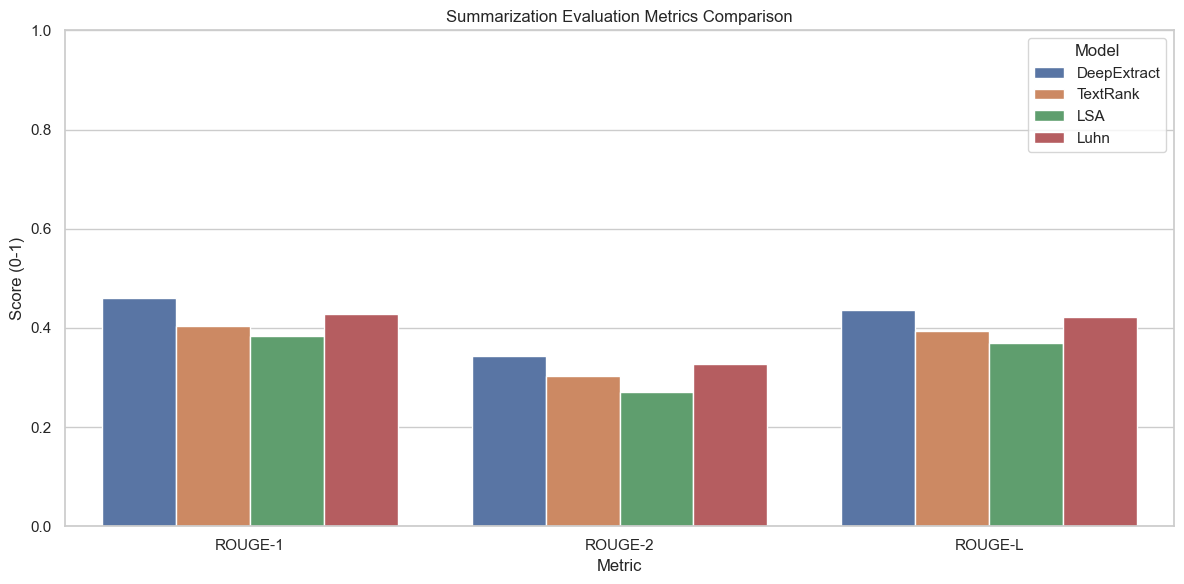

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the evaluation results
df = pd.read_csv("summary_evaluation_results1.csv")

# Define models and corresponding metric columns
models = {
    "DeepExtract": ['sys_rouge1', 'sys_rouge2', 'sys_rougel', 'sys_su4', 'bleu_sys', 'meteor_sys', 'sacrebleu_sys'],
    "TextRank":    ['text_rank_rouge1', 'text_rank_rouge2', 'text_rank_rougel', 'text_rank_su4', 'bleu_tr', 'meteor_tr', 'sacrebleu_tr'],
    "LSA":         ['lsa_rouge1', 'lsa_rouge2', 'lsa_rougel', 'lsa_su4', 'bleu_lsa', 'meteor_lsa', 'sacrebleu_lsa'],
    "Luhn":        ['luhn_rouge1', 'luhn_rouge2', 'luhn_rougel', 'luhn_su4', 'bleu_luhn', 'meteor_luhn', 'sacrebleu_luhn'],
   
}

metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Compute average scores for each method
plot_data = []
for model, cols in models.items():
    averages = df[cols].mean().tolist()
    for metric, score in zip(metric_names, averages):
        plot_data.append({'Model': model, 'Metric': metric, 'Score': score})

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=plot_df, x="Metric", y="Score", hue="Model")
plt.title("Summarization Evaluation Metrics Comparison")
plt.ylim(0, 1)
plt.ylabel("Score (0-1)")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("summary_comparison_plot.png")
plt.show()


In [16]:
import pandas as pd

# Load the evaluation results
df = pd.read_csv("summary_evaluation_results1.csv")

# Define only the ROUGE-related metric columns
models = {
    "DeepExtract": ['sys_rouge1', 'sys_rouge2', 'sys_rougel'],
    "TextRank":    ['text_rank_rouge1', 'text_rank_rouge2', 'text_rank_rougel'],
    "LSA":         ['lsa_rouge1', 'lsa_rouge2', 'lsa_rougel'],
    "Luhn":        ['luhn_rouge1', 'luhn_rouge2', 'luhn_rougel'],
}

# Metric labels
metric_labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Prepare the table data
table_data = {}
for model_name, metric_cols in models.items():
    averages = df[metric_cols].mean()
    table_data[model_name] = averages.values

# Convert to DataFrame
score_table = pd.DataFrame(table_data, index=metric_labels).T  # Transpose for readability

# Display the score table
print("\n=== Summarization ROUGE Score Table ===\n")
print(score_table.round(4))



=== Summarization ROUGE Score Table ===

             ROUGE-1  ROUGE-2  ROUGE-L
DeepExtract   0.4605   0.3430   0.4361
TextRank      0.4031   0.3029   0.3934
LSA           0.3831   0.2717   0.3702
Luhn          0.4279   0.3265   0.4211


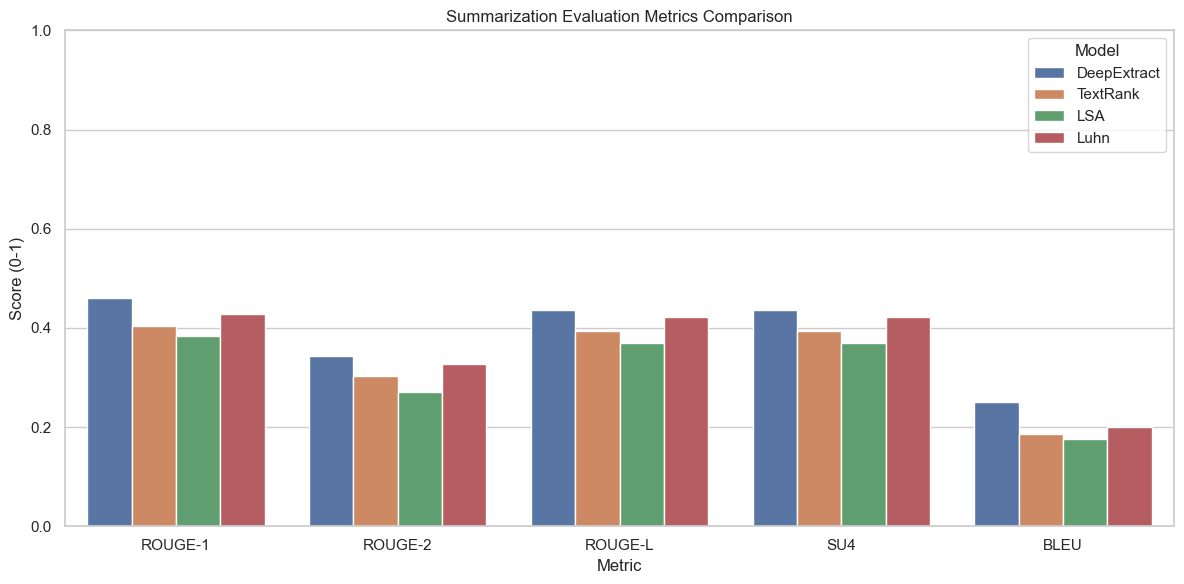

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the evaluation results
df = pd.read_csv("summary_evaluation_results1.csv")

# Define models and corresponding metric columns
models = {
    "DeepExtract": ['sys_rouge1', 'sys_rouge2', 'sys_rougel', 'sys_su4', 'bleu_sys', 'meteor_sys', 'sacrebleu_sys'],
    "TextRank":    ['text_rank_rouge1', 'text_rank_rouge2', 'text_rank_rougel', 'text_rank_su4', 'bleu_tr', 'meteor_tr', 'sacrebleu_tr'],
    "LSA":         ['lsa_rouge1', 'lsa_rouge2', 'lsa_rougel', 'lsa_su4', 'bleu_lsa', 'meteor_lsa', 'sacrebleu_lsa'],
    "Luhn":        ['luhn_rouge1', 'luhn_rouge2', 'luhn_rougel', 'luhn_su4', 'bleu_luhn', 'meteor_luhn', 'sacrebleu_luhn'],
   
}

metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'SU4', 'BLEU']
#metric_names = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']

# Compute average scores for each method
plot_data = []
for model, cols in models.items():
    averages = df[cols].mean().tolist()
    for metric, score in zip(metric_names, averages):
        plot_data.append({'Model': model, 'Metric': metric, 'Score': score})

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Plot
plt.figure(figsize=(12, 6))
#plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="Metric", y="Score", hue="Model")
plt.title("Summarization Evaluation Metrics Comparison")
plt.ylim(0, 1)
plt.ylabel("Score (0-1)")
plt.legend(title="Model")
plt.tight_layout()
plt.savefig("summary_comparison_plot.png")
plt.show()
